In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# 1. Data Loading and Basic Information
print("=== HDB Resale Price Data Analysis ===")
print("\n1. Data Loading and Basic Information")

# Load data
data_path = '../Dataset'
df = pd.read_csv(data_path +'/train_with_mall_features_and_hdb_coordinates_and_postal_code.csv')
print(f"Dataset shape: {df.shape}")
print(f"Dataset contains {df.shape[0]} records and {df.shape[1]} features")

# Display first few rows
print("\nFirst 5 rows of data:")
print(df.head())

# Basic data information
print("\nBasic data information:")
print(df.info())

# Descriptive statistics
print("\nDescriptive statistics for numerical features:")
print(df.describe())

=== HDB Resale Price Data Analysis ===

1. Data Loading and Basic Information
Dataset shape: (162464, 18)
Dataset contains 162464 records and 18 features

First 5 rows of data:
     MONTH           TOWN FLAT_TYPE BLOCK              STREET FLOOR_RANGE  \
0  2020-10      woodlands    4-room  681B  woodlands drive 62    07 to 09   
1  2021-07         bishan    4-room   264    bishan street 24    07 to 09   
2  2021-05  bukit panjang    4-room   520       jelapang road    19 to 21   
3  2021-08        punggol    4-room  121B     edgedale plains    16 to 18   
4  2023-05        hougang    5-room  997B   buangkok crescent    10 to 12   

   FLOOR_AREA_SQM         FLAT_MODEL   ECO_CATEGORY  LEASE_COMMENCE_DATA  \
0           102.0  premium apartment  uncategorized                 2000   
1           104.0            model a  uncategorized                 1992   
2           102.0            model a  uncategorized                 1998   
3            93.0            model a  uncategorized     

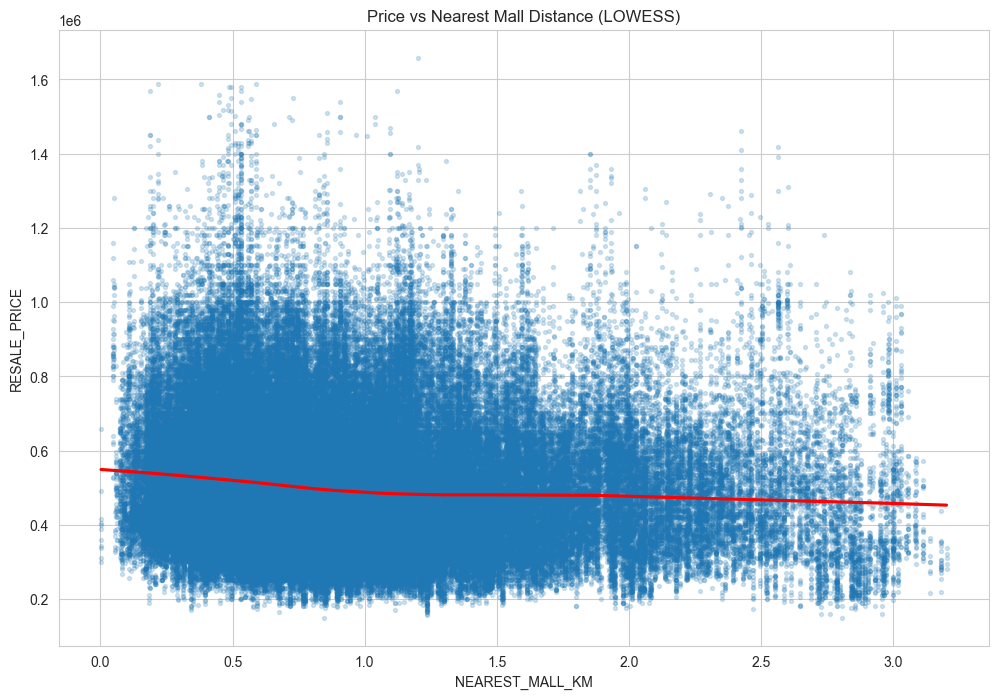

In [2]:
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['NEAREST_MALL_KM','RESALE_PRICE'])
sns.regplot(data=df, x='NEAREST_MALL_KM', y='RESALE_PRICE', scatter_kws={'alpha':0.2, 's':8}, lowess=True, line_kws={'color':'red'})
plt.title('Price vs Nearest Mall Distance (LOWESS)')
plt.show()


Resale Price and Shopping Mall Proximity Features Correlation Analysis


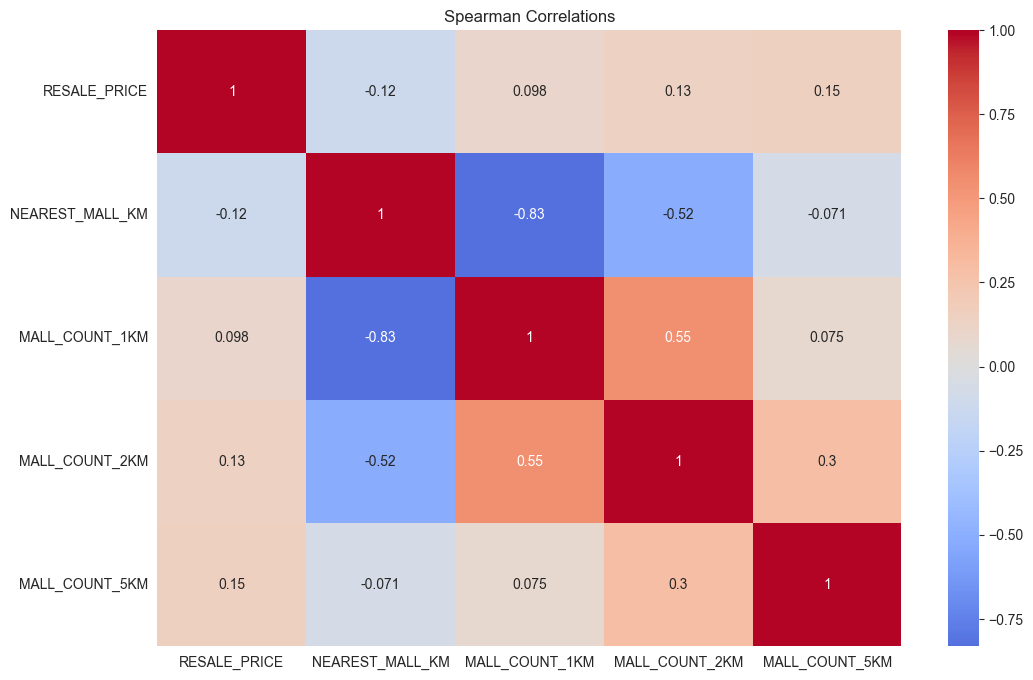

Correlation Matrix:
                 RESALE_PRICE  NEAREST_MALL_KM  MALL_COUNT_1KM  \
RESALE_PRICE         1.000000        -0.122467        0.097550   
NEAREST_MALL_KM     -0.122467         1.000000       -0.831307   
MALL_COUNT_1KM       0.097550        -0.831307        1.000000   
MALL_COUNT_2KM       0.134790        -0.522792        0.549045   
MALL_COUNT_5KM       0.153598        -0.070508        0.075073   

                 MALL_COUNT_2KM  MALL_COUNT_5KM  
RESALE_PRICE           0.134790        0.153598  
NEAREST_MALL_KM       -0.522792       -0.070508  
MALL_COUNT_1KM         0.549045        0.075073  
MALL_COUNT_2KM         1.000000        0.298381  
MALL_COUNT_5KM         0.298381        1.000000  

--- Analysis of Correlations ---


In [3]:
print("\nResale Price and Shopping Mall Proximity Features Correlation Analysis")
cols = ['RESALE_PRICE','NEAREST_MALL_KM','MALL_COUNT_1KM','MALL_COUNT_2KM','MALL_COUNT_5KM']
correlation_matrix = df[cols].corr(method='spearman')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Spearman Correlations'); plt.show()
print("Correlation Matrix:")
print(correlation_matrix)
print("\n--- Analysis of Correlations ---")

In [4]:
df_shopping_malls=pd.read_csv(data_path+'/auxiliary-data/sg-shopping-malls.csv')

In [5]:
sub = df.sample(min(len(df), 30000), random_state=42).dropna(subset=['LATITUDE','LONGITUDE',"RESALE_PRICE"])
malls=df_shopping_malls.dropna(subset=['LATITUDE','LONGITUDE'])
# plt.figure(figsize=(7,8))
# sc = plt.scatter(sub['LONGITUDE'], sub['LATITUDE'],
#                  c=sub['RESALE_PRICE'], s=5, alpha=0.4, cmap='plasma')
# plt.scatter(malls['LONGITUDE'], malls['LATITUDE'],
#             marker='x', c='k', s=20, label='Shopping malls')
# plt.colorbar(sc, label='Resale price')
# plt.title('Price map with mall locations')
# plt.xlabel('Lon'); plt.ylabel('Lat'); plt.legend()
# plt.show()


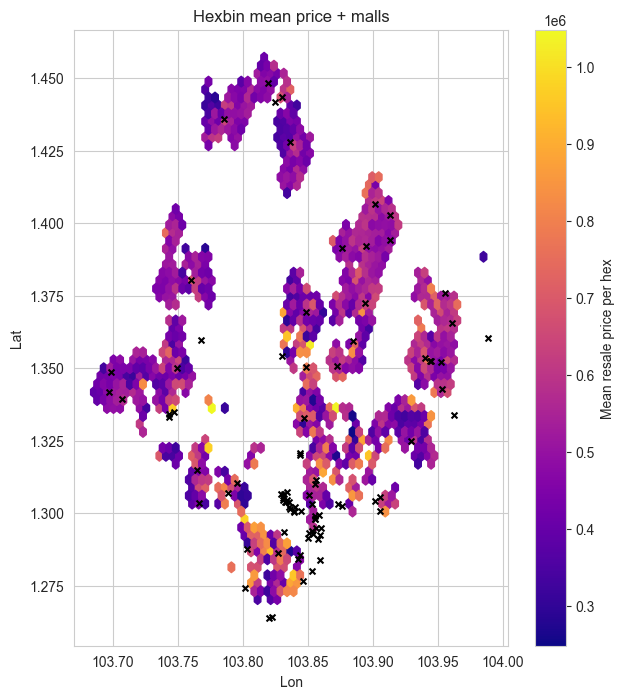

Median price by proximity group:
MALL_COUNT_2KM
<4 malls     480000.0
>=4 malls    520000.0
Name: RESALE_PRICE, dtype: float64


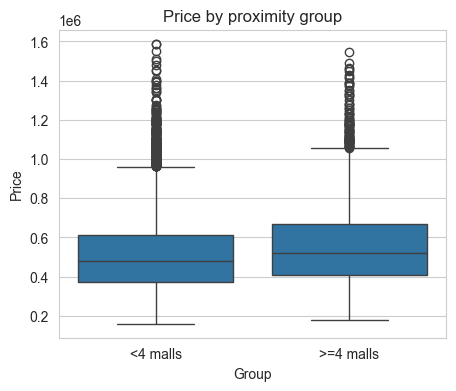

In [7]:
plt.figure(figsize=(7,8))
hb = plt.hexbin(sub['LONGITUDE'], sub['LATITUDE'],
                C=sub['RESALE_PRICE'], gridsize=60,
                reduce_C_function=np.mean, cmap='plasma')
plt.scatter(malls['LONGITUDE'], malls['LATITUDE'], marker='x', c='k', s=18)
plt.colorbar(hb, label='Mean resale price per hex')
plt.title('Hexbin mean price + malls')
plt.xlabel('Lon'); plt.ylabel('Lat')
plt.savefig('../Plots/hexbin_mean_price_malls.png')
plt.show()

mask = sub['MALL_COUNT_2KM'] >=4 
print('Median price by proximity group:')
print(sub.groupby(mask)['RESALE_PRICE'].median().rename({False:'<4 malls', True:'>=4 malls'}))

plt.figure(figsize=(5,4))
sns.boxplot(data=sub.assign(group=np.where(mask, '>=4 malls', '<4 malls')),
            x='group', y='RESALE_PRICE')
plt.title('Price by proximity group'); plt.xlabel('Group'); plt.ylabel('Price')
plt.savefig('../Plots/boxplot_price_malls_proximity.png')
plt.show()

In [10]:
bins = [0,0.5,1,2,3,5,10]
lab  = ['≤0.5km','0.5-1km','1-2km','2-3km','3-5km','>5km']
tmp = (df
       .dropna(subset=['NEAREST_MALL_KM','RESALE_PRICE'])
       .assign(dist_bin=pd.cut(df['NEAREST_MALL_KM'], bins=bins, labels=lab, include_lowest=True))
       .groupby('dist_bin',observed=False)['RESALE_PRICE'].agg(['count','median','mean']).reset_index())

print("Analysis of Resale Price by Distance to Nearest Mall")
print("The table below shows the count, median, and mean resale prices for each distance bin to the nearest mall.")
print(tmp)
print("We can see that the median price and mean price generally increases with increasing distance to the nearest mall.")
print("The count of transactions also decreases with increasing distance, indicating that buyers may be more willing to pay a premium for properties closer to malls.")

Analysis of Resale Price by Distance to Nearest Mall
The table below shows the count, median, and mean resale prices for each distance bin to the nearest mall.
  dist_bin  count    median           mean
0   ≤0.5km  33603  518000.0  549303.517894
1  0.5-1km  63177  490000.0  523267.522897
2    1-2km  53505  470000.0  502718.481070
3    2-3km  11829  460000.0  483900.317853
4    3-5km    350  435000.0  464167.645714
5     >5km      0       NaN            NaN
We can see that the median price and mean price generally increases with increasing distance to the nearest mall.
The count of transactions also decreases with increasing distance, indicating that buyers may be more willing to pay a premium for properties closer to malls.
